In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot
import platform
from matplotlib import font_manager, rc
import csv

import warnings
warnings.filterwarnings('ignore')

In [14]:
plt.rcParams['axes.unicode_minus'] = False
if platform.system() == 'Darwin':
    rc('font', family = 'AppleGothic')
elif platform.system() == 'Windows':
    path ='C:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Can't find your system.")

In [15]:
df = pd.read_csv('./Data/22.세종시_연령별_인구현황.csv', index_col='읍면동') 
# df.head()

### 데이터 전처리
* 2019년을 분석하기 위해 2019년 데이터를 분리하여 세종특별자치시의 연령별 데이터로 바꾸는 전처리 진행

In [16]:
df = df.transpose()

In [17]:
df_2019 = df[624:936]
# 성별별 총 거주자수로 분리

In [18]:
df_2019.reset_index(inplace=True)

In [19]:
df_2019.columns = ['month','세종특별자치시', '조치원읍', '연기면', '연동면', '부강면', '금남면', '장군면', '연서면', '전의면',
       '전동면', '소정면', '한솔동', '새롬동', '도담동', '아름동', '종촌동', '고운동', '소담동', '보람동',
       '대평동', '다정동']

In [20]:
df_2019_m = pd.DataFrame()
df_2019_w = pd.DataFrame()

for i in range(0,12):
    df_2019_m = pd.concat([df_2019_m, df_2019.loc[i*26 : i*26+12]],axis=0)
    df_2019_w = pd.concat([df_2019_w, df_2019.loc[i*26+13 : i*26+25]],axis=0)
    df_2019_m = df_2019_m.drop(df_2019_m.index[i*11 : i*11+2]).reset_index(drop=True)
    df_2019_w = df_2019_w.drop(df_2019_w.index[i*11 : i*11+2]).reset_index(drop=True)

In [21]:
df_2019_m_y = pd.DataFrame()
df_2019_w_y = pd.DataFrame()
temp1 = pd.DataFrame()
temp2 = pd.DataFrame()

for i in range(0,11):
    for j in range(0,12):
        temp1 = pd.concat([temp1,df_2019_m.loc[[j*11+i]]],axis=0)
        temp2 = pd.concat([temp2,df_2019_w.loc[[j*11+i]]],axis=0)
        
    df_2019_m_y = pd.concat([df_2019_m_y,pd.DataFrame(temp1[i*12:i*12+12].mean()).transpose()],axis=0)    
    df_2019_w_y = pd.concat([df_2019_w_y,pd.DataFrame(temp2[i*12:i*12+12].mean()).transpose()],axis=0)    
    
df_2019_m_y.index = list(range(0,110,10))
df_2019_w_y.index = list(range(0,110,10))

In [22]:
df1 = pd.DataFrame(df_2019_m_y['세종특별자치시'] + df_2019_w_y['세종특별자치시'])
df1['연령별'] = ['0~9세','10~19세','20~29세','30~39세','40~49세','50~59세',
       '60~69세','70~79세','80~89세','90~99세','100세 이상']

In [23]:
df1 = df1.convert_dtypes()
df1['sejong'] = df1['세종특별자치시'].astype(int)
df1

,세종특별자치시,연령별,sejong
0,46066.583333,0~9세,46066
10,38606.750000,10~19세,38606
20,35197.333333,20~29세,35197
30,60054.083333,30~39세,60054
40,61491.750000,40~49세,61491
50,40503.250000,50~59세,40503
60,25674.333333,60~69세,25674
70,12948.916667,70~79세,12948
80,6461.833333,80~89세,6461
90,972.333333,90~99세,972


### 데이터 파이차트 시각화
* 데이터의 연령분포를 파악하기 위한 파이차트로 시각화

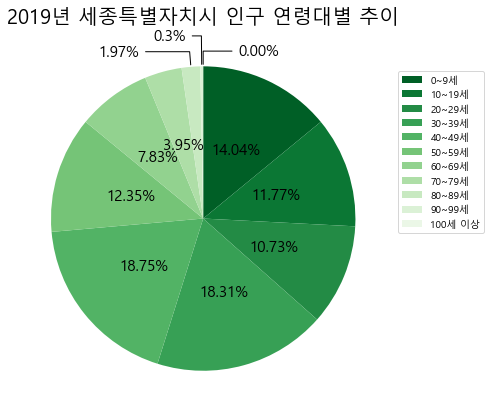

In [27]:
labels = df1['연령별'] ## 라벨
frequency = df1['sejong']#df1['세종특별자치시'].astype(int) #df1['pct'] ## 빈도
colors = sns.color_palette('Greens_r',len(labels))
fig = plt.figure(figsize=(7,7))
fig.set_facecolor('white')
ax = fig.add_subplot()
pie = ax.pie(frequency, 
             startangle=90, 
             counterclock=False,
             colors=colors) #, autopct='%1.1f%%'
total = sum(frequency) ## 빈도수 합
threshold = 3 ## 상한선 비율
sum_pct = 0 ## 퍼센티지
bbox_props = dict(boxstyle='square',fc='w',ec='w',alpha=0) ## annotation 박스 스타일
## annotation 설정
config = dict(arrowprops=dict(arrowstyle='-'),bbox=bbox_props,va='center')
for i,l in enumerate(labels):
    ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 ## 파이의 시작 각도와 끝 각도
    center, r = ax.patches[i].center, ax.patches[i].r ## 원의 중심 좌표와 반지름길이
    if i < len(labels) - 1:
        sum_pct += (frequency.iloc[i]/total*100).round(2)
        text = f'{(frequency.iloc[i]/total*100).round(2)}%'
    else: ## 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
        text = f'{100-sum_pct:.2f}%'
    ## 비율 상한선보다 작은 것들은 Annotation으로 만든다.
    if frequency.iloc[i]/total*100 < threshold and i < len(labels) - 3:
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(1.5*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **config,fontsize=15)
    elif frequency.iloc[i]/total*100 < threshold and i == len(labels) - 3:#마지막
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(1.5*x-0.3, 1.2*y-0.1),
                    horizontalalignment=horizontalalignment, **config,fontsize=15)
    elif frequency.iloc[i]/total*100 < threshold and i == len(labels) - 2:#마지막
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(1.5*x-0.1, 1.2*y),
                    horizontalalignment=horizontalalignment, **config,fontsize=15) 
    elif frequency.iloc[i]/total*100 < threshold and i == len(labels) - 1:#마지막
        ang = (ang1+ang2)/2 ## 중심각
        x = np.cos(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 x좌표
        y = np.sin(np.deg2rad(ang)) ## Annotation의 끝점에 해당하는 y좌표
        ## x좌표가 양수이면 즉 y축을 중심으로 오른쪽에 있으면 왼쪽 정렬
        ## x좌표가 음수이면 즉 y축을 중심으로 왼쪽에 있으면 오른쪽 정렬
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang) ## 시작점과 끝점 연결 스타일
        config["arrowprops"].update({"connectionstyle": connectionstyle}) ## 
        ax.annotate(text, xy=(x, y), xytext=(1.5*x+0.5, 1.2*y-0.1),
                    horizontalalignment=horizontalalignment, **config,fontsize=15) 
    else:
        x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] ## 텍스트 x좌표
        y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] ## 텍스트 y좌표
        ax.text(x,y,text,ha='center',va='center',fontsize=15)
plt.legend(labels,bbox_to_anchor=(1, 0.9))
plt.title('2019년 세종특별자치시 인구 연령대별 추이',fontsize=20)
plt.show()